<a href="https://colab.research.google.com/github/vasanthav/Swift-Application/blob/master/NLP_Project_Full_Code_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

**Note**: If the free-tier GPU of Google Colab is not accessible (due to unavailability or exhaustion of daily limit or other reasons), the following steps can be taken:

1. Wait for 12-24 hours until the GPU is accessible again or the daily usage limits are reset.

2. Switch to a different Google account and resume working on the project from there.

3. Try using the CPU runtime:
    - To use the CPU runtime, click on *Runtime* => *Change runtime type* => *CPU* => *Save*
    - One can also click on the *Continue without GPU* option to switch to a CPU runtime (kindly refer to the snapshot below)
    - The instructions for running the code on the CPU are provided in the respective sections of the notebook.

## **Installing and Importing Necessary Libraries**

In [ ]:
!pip install -U sentence-transformers==4.0.2 gensim==4.3.3 transformers==4.50.3 tqdm==4.67.1 scikit-learn==1.6.1 pandas==2.2.2 numpy==1.26.4 matplotlib==3.10.0 seaborn==0.13.2 -q

In [ ]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To parse JSON data
import json

# To build, tune, and evaluate ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Write your code here to read the data
df = pd.read_csv('/content/drive/MyDrive/AI_ML_Interview/1_AI_ML_Course/8_Introduction_to_Natural_Language_Processing/Project/stock_news.csv')
df2 = df.copy()

## **Data Overview**

**First and last few rows of the dataset**

In [ ]:
# view the first 5 rows of the dataset
df2.head()

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
# view the last 5 rows of the dataset
df2.tail()

,Date,News,Open,High,Low,Close,Volume,Label
344,2019-04-30,"Media mogul Oprah Winfrey, known for influenc...",50.764999,50.849998,49.7775,48.70879,186139600,-1
345,2019-04-30,"European shares fell on Tuesday, with banks u...",50.764999,50.849998,49.7775,48.70879,186139600,-1
346,2019-04-30,This article reports that the S&P 500 reached...,50.764999,50.849998,49.7775,48.70879,186139600,-1
347,2019-04-30,The Federal Reserve is anticipated to keep in...,50.764999,50.849998,49.7775,48.70879,186139600,-1
348,2019-04-30,"In the first quarter, South Korea's Samsung E...",50.764999,50.849998,49.7775,48.70879,186139600,0


In [ ]:
# view the shape of the dataset
df2.shape

(349, 8)

* Dataset has 8 columns and 349 rows





In [ ]:
# view the datatypes of the columns of the dataset
df2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


* There are 2 categorical columns and 6 numerical columns

In [ ]:
# Convert 'Date' column to datetime format
df2['Date'] = pd.to_datetime(df2['Date'])

In [ ]:
# check the datatypes of the columns of the dataset
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


In [ ]:
#statistical summary of the dataset
df2.describe()

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


* The Dates of the data gathered ranges from 2019-01-02 to 2019-04-30 which is around 4 months
* The median value that the stocks went high is around ~46
* The stock prices ranges from around 36 to 67

In [ ]:
# Check for missing values
df2.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


* The dataset doesn't have any missing values

In [ ]:
# Check for duplicated values
df2.duplicated().sum()

0

* There are no duplicated values in the dataset

## **Exploratory Data Analysis**

### Univariate Analysis

* Distribution of individual variables
* Compute and check the distribution of the length of news content

###Observations on Label

<Axes: xlabel='Label', ylabel='percent'>

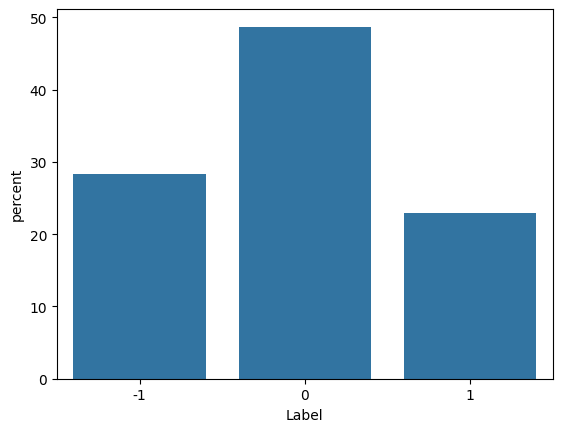

In [ ]:
sns.countplot(data=df2, x='Label', stat='percent')

* The news is more for label with neutral polarity

### Density of stock price at different times and levels

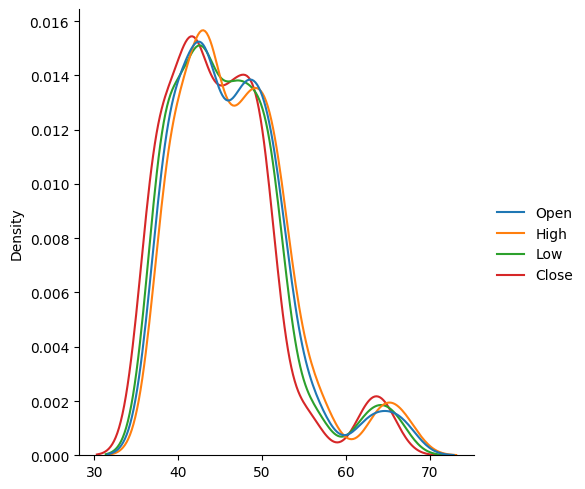

In [ ]:
sns.displot(data=df2[['Open', 'High', 'Low', 'Close']], kind="kde", palette="tab10");

* The distribution of the prices are around the same ranges and similar with slight difference

###Observations on Volume

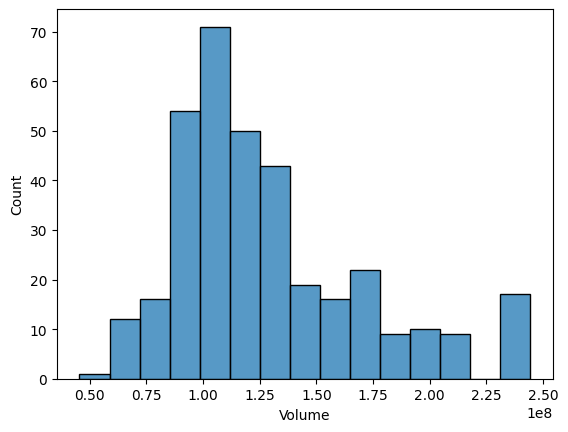

In [ ]:
sns.histplot(df2, x='Volume');

* The majority of the volume of shares traded are between 80 to 175million
* Some days have more than 200 million shares traded
* The max volume is around 240 million shares traded.

###Observations on News length

In [ ]:
df2['news_len'] = df2['News'].apply(lambda x: len(x.split(' ')))
df2['news_len'].describe()

,news_len
count,349.000000
mean,49.312321
std,5.727770
min,19.000000
25%,46.000000
50%,50.000000
75%,53.000000
max,61.000000


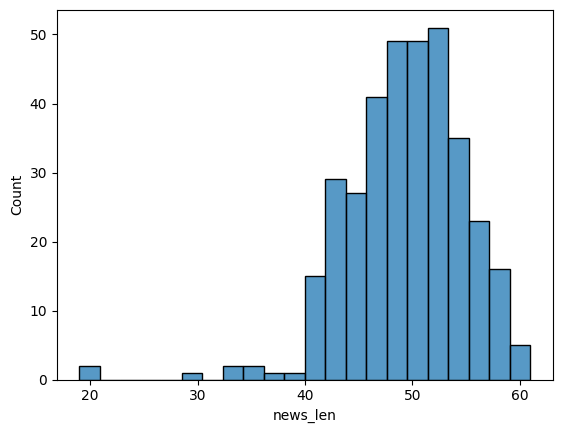

In [ ]:
sns.histplot(data=df2,x="news_len");

* Most of the news articles is between 40 to 60 words
* Very few news articles is less then 40 words
* Average of the news articles is around 50 words

### Bivariate Analysis

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

###Correlation


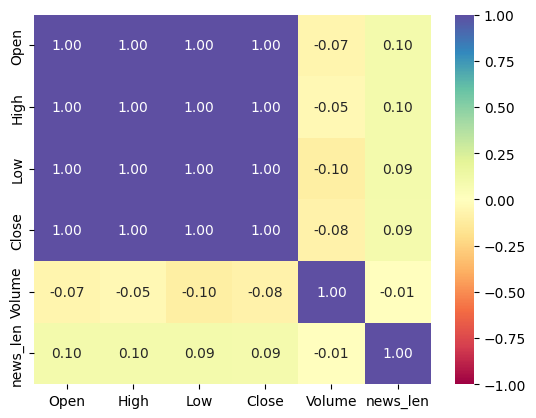

In [ ]:
cols = ['Open', 'High', 'Low', 'Close', 'Volume', "news_len"]
sns.heatmap(
    df2[cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
);

* The prices Open, High, Low, Close are perfecly correlated.
* Volume has slightly negative correlation with the prices. Higher Volume leads to lower prices.
* Slightly positive correlation with news length. Longer news length leads to higher prices.

###Label vs Price (Open, High, Low, Close)

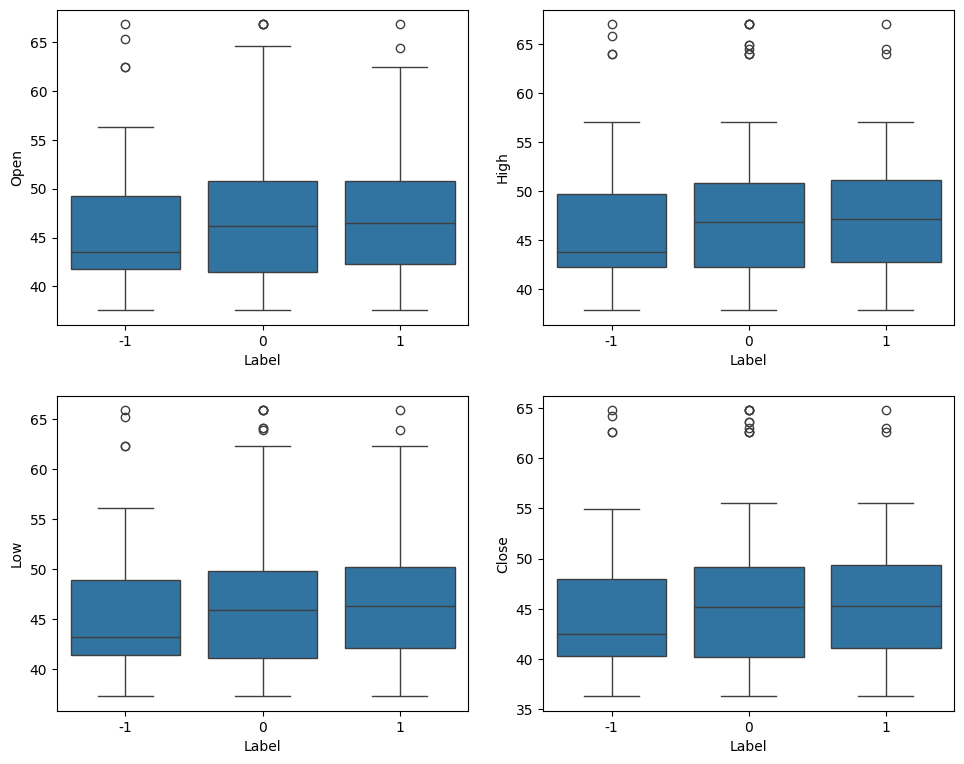

In [ ]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df2, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

* The median for all prices is lower for negative setiment of news article which shows negative news lowers the stock price.
* Postive sentiment of news articles didnot affect the prices of the stocks

###Label vs Volume

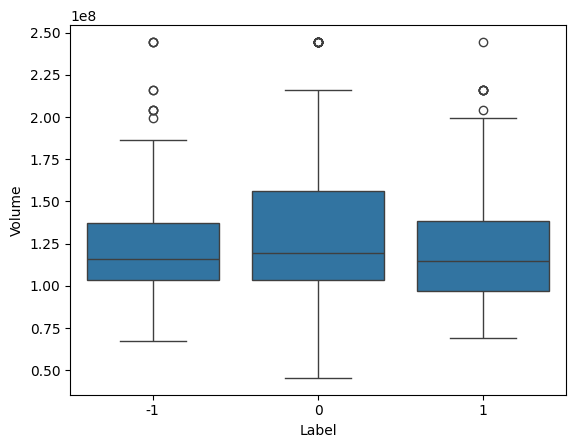

In [ ]:
sns.boxplot(
    data=df2, x="Label", y="Volume"
);

* The medians of volume is approximately same across of all the news articles sentiments.
* There are some outliers for negative sentiment news
* The range of volume is spread more for neutral sentiment news.

###Date vs Price (Open, High, Low, Close)

In [ ]:
stock_daily = df2.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


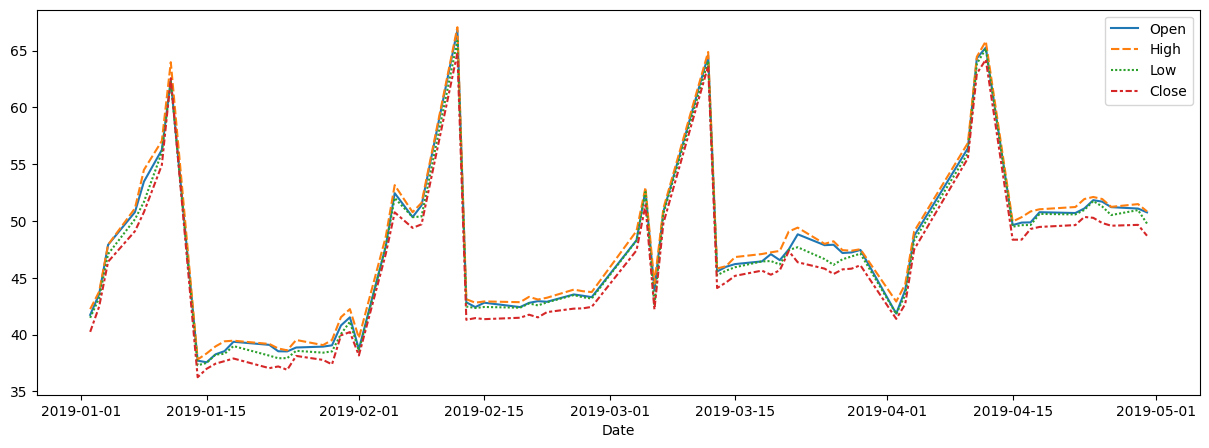

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop("Volume", axis=1));

* The stock price is increased from 40 to 50 across 4 months.
* There seems to be similar pattern in each month going higher and immediately going lower.

###Volume vs Close Price

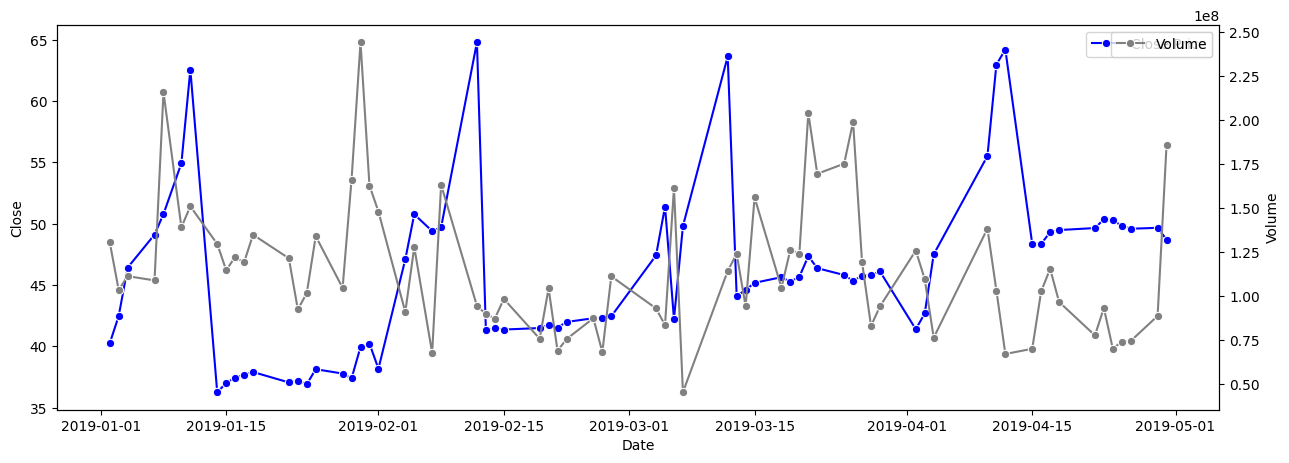

In [ ]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

* There is no specific pattern here. Volume doesn't seem have a correlation with the price.

## **Data Preprocessing**

In [ ]:
df2["Date"].describe()

,Date
count,349
mean,2019-02-16 16:05:30.085959936
min,2019-01-02 00:00:00
25%,2019-01-14 00:00:00
50%,2019-02-05 00:00:00
75%,2019-03-22 00:00:00
max,2019-04-30 00:00:00


* 75% of the data is till March2019.
* We can take April data and split it into validation and test sets.

###Train-test-validation Split

In [ ]:
X_train = df2[(df2['Date'] < '2019-04-01')].reset_index()
X_val = df2[(df2['Date'] >= '2019-04-01') & (df2['Date'] < '2019-04-16')].reset_index()
X_test = df2[df2['Date'] >= '2019-04-16'].reset_index()

In [ ]:
y_train = X_train["Label"].copy()
y_val = X_val["Label"].copy()
y_test = X_test["Label"].copy()

In [ ]:
print("Train data shape",X_train.shape)
print("Validation data shape",X_val.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Validation label shape",y_val.shape)
print("Test label shape ",y_test.shape)

Train data shape (286, 10)
Validation data shape (21, 10)
Test data shape  (42, 10)
Train label shape (286,)
Validation label shape (21,)
Test label shape  (42,)


In [ ]:
y_train.value_counts(normalize=True)

,proportion
Label,
0,0.482517
-1,0.286713
1,0.230769


In [ ]:
y_val.value_counts(normalize=True)

,proportion
Label,
0,0.571429
1,0.238095
-1,0.190476


In [ ]:
y_test.value_counts(normalize=True)

,proportion
Label,
0,0.476190
-1,0.309524
1,0.214286


## **Word Embeddings**

###Word2Vec

In [ ]:
words_list = [item.split(" ") for item in df2['News'].values]

In [ ]:
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


In [ ]:
# Checking the word embedding of a random word
word = "shares"
model_W2V.wv[word]

array([-0.00051333,  0.02360626,  0.00496829,  0.0156298 , -0.00611361,
       -0.0287023 ,  0.0200332 ,  0.05480686,  0.00591843, -0.00489041,
        0.0091043 , -0.01181393,  0.00172265,  0.00375626, -0.018123  ,
       -0.02109684,  0.01442942, -0.00796665, -0.00021112, -0.00683862,
       -0.01813203,  0.00291275,  0.02682349,  0.00653472,  0.01229824,
        0.0018448 , -0.02968821,  0.00575803, -0.01178766, -0.02262227,
        0.00999625, -0.01367747,  0.00211228, -0.00343919, -0.00529124,
        0.00590557,  0.01206259, -0.02657029, -0.00021121, -0.00738524,
       -0.00781965, -0.00398153,  0.00357538, -0.01617534,  0.01110853,
        0.02726638,  0.0002744 ,  0.00723813, -0.0023202 ,  0.01761253,
        0.00983541,  0.00744666, -0.00808403,  0.0050396 , -0.00440452,
        0.01521285,  0.00786643,  0.00042685,  0.00986175, -0.00340378,
       -0.00806723, -0.01194375,  0.00126763,  0.00657059,  0.00374211,
        0.00608261, -0.00012207,  0.01123802, -0.01651678, -0.00

In [ ]:
# Checking the word embedding of a random word
word = "tariff"
model_W2V.wv[word]

array([-2.71570822e-03,  3.79518769e-03,  4.88977414e-04,  1.81572337e-03,
       -5.55313949e-04, -6.54098054e-04, -6.49228110e-04,  7.96768814e-03,
        3.44189536e-03, -6.86729676e-04,  1.49614702e-03, -3.52675118e-03,
       -1.08244293e-03, -8.55834340e-04,  1.83436251e-03, -4.58127167e-03,
        2.41866801e-03,  1.60423631e-03, -2.82594492e-03, -3.09266034e-03,
       -1.16420975e-04, -2.72923638e-03, -6.53597934e-04,  3.44056357e-03,
       -4.27123916e-04,  3.40874866e-03, -4.69616195e-03, -6.47116860e-04,
       -2.00673076e-03, -5.03307814e-03,  1.76403066e-03, -2.77357321e-04,
       -2.56466633e-03, -1.70906750e-03, -3.48717766e-03,  1.49711035e-04,
       -1.44552137e-03, -1.86324847e-04,  9.44137573e-04, -2.46885838e-03,
       -2.54148897e-03,  1.50404975e-03,  1.63048517e-03, -1.07754651e-03,
        2.30754167e-03,  4.85369377e-03,  2.78220163e-03, -1.91160047e-03,
       -4.70436295e-04,  4.85142553e-03,  3.98171367e-03, -1.67850940e-03,
       -3.27203679e-03,  

In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_wv = pd.DataFrame(X_val["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test["News"].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.641638994216919


In [ ]:
print(X_train_wv.shape, X_val_wv.shape, X_test_wv.shape)

(286, 300) (21, 300) (42, 300)


###Glove

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving glove.6B.100d.txt.word2vec to glove.6B.100d.txt.word2vec


In [ ]:
filename = 'glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [ ]:
word = "stock"
glove_model[word]

array([ 8.6341e-01,  6.9648e-01,  4.5794e-02, -9.5708e-03, -2.5498e-01,
       -7.4666e-01, -2.2086e-01, -4.4615e-01, -1.0423e-01, -9.9931e-01,
        7.2550e-02,  4.5049e-01, -5.9912e-02, -5.7837e-01, -4.6540e-01,
        4.3429e-02, -5.0570e-01, -1.5442e-01,  9.8250e-01, -8.1571e-02,
        2.6523e-01, -2.3734e-01,  9.7675e-02,  5.8588e-01, -1.2948e-01,
       -6.8956e-01, -1.2811e-01, -5.2265e-02, -6.7719e-01,  3.0190e-02,
        1.8058e-01,  8.6121e-01, -8.3206e-01, -5.6887e-02, -2.9578e-01,
        4.7180e-01,  1.2811e+00, -2.5228e-01,  4.9557e-02, -7.2455e-01,
        6.6758e-01, -1.1091e+00, -2.0493e-01, -5.8669e-01, -2.5375e-03,
        8.2777e-01, -4.9102e-01, -2.6475e-01,  4.3015e-01, -2.0516e+00,
       -3.3208e-01,  5.1845e-02,  5.2646e-01,  8.7452e-01, -9.0237e-01,
       -1.7366e+00, -3.4727e-01,  1.6590e-01,  2.7727e+00,  6.5756e-02,
       -4.0363e-01,  3.8252e-01, -3.0787e-01,  5.9202e-01,  1.3468e-01,
       -3.3851e-01,  3.3646e-01,  2.0950e-01,  8.5905e-01,  5.18

In [ ]:
word = "economy"
glove_model[word]

array([-0.19382  ,  1.017    ,  1.076    ,  0.02954  , -0.39192  ,
       -1.3891   , -0.87873  , -0.63162  ,  0.9643   , -0.43035  ,
       -0.34868  ,  0.22736  , -0.40296  ,  0.15641  , -0.16813  ,
       -0.15343  , -0.15799  , -0.27612  ,  0.18088  , -0.28386  ,
        0.49847  ,  0.29864  ,  0.32353  ,  0.18108  , -0.59623  ,
       -0.54165  , -0.70019  , -0.64956  , -0.69063  ,  0.18084  ,
       -0.38581  ,  0.56086  , -0.40313  , -0.38777  , -0.70615  ,
        0.20657  ,  0.34171  , -0.23393  , -0.35882  , -0.2201   ,
       -0.76182  , -1.2047   ,  0.4339   ,  1.1656   ,  0.1836   ,
       -0.21601  ,  0.93198  , -0.059616 , -0.11624  , -1.3259   ,
       -0.79772  , -0.0074957, -0.0889   ,  1.4749   ,  0.31157  ,
       -2.2952   , -0.058351 ,  0.39353  ,  1.4983   ,  0.74023  ,
       -0.20109  ,  0.098124 , -0.73081  , -0.32294  ,  0.16703  ,
        0.87431  , -0.041624 , -0.51022  ,  1.0737   , -0.4257   ,
        1.0581   ,  0.19859  , -0.60087  , -0.33906  ,  0.6024

In [ ]:
# Retrieving the words present in the GloVe model's vocabulary
glove_words = glove_model.index_to_key

# Creating a dictionary of words and their corresponding vectors
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
vec_size=100

In [ ]:
def average_vectorizer_GloVe(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_gl = pd.DataFrame(X_train["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_val_gl = pd.DataFrame(X_val["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_gl = pd.DataFrame(X_test["News"].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  43.89286398887634


In [ ]:
print(X_train_gl.shape, X_val_gl.shape, X_test_gl.shape)

(286, 100) (21, 100) (42, 100)


####Sentence Transformer

####Defining the model

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

####Encoding the dataset

In [ ]:
# setting the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device=device)
X_val_st = model.encode(X_val["News"].values, show_progress_bar=True, device=device)
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device=device)

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Time taken  13.01815915107727


In [ ]:
print(X_train_st.shape, X_val_st.shape, X_test_st.shape) #Complete the code to print the shapes of the final dataframes

(286, 384) (21, 384) (42, 384)


## **Sentiment Analysis**

####Model Evaluation Criterion

* Using F1 Score will be better as the accuracy of the news impacts decision-making
* F1 Score balances precision and recall

####Utility Functions

In [ ]:
def plot_confusion_matrix(model, predictors, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    cm = confusion_matrix(target, pred)  # Compute the confusion matrix.

    plt.figure(figsize=(5, 4))  # Create a new figure with a specified size.
    label_list = [0, 1,-1]  # Define the labels for the confusion matrix.
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
    # Plot the confusion matrix using a heatmap with annotations.

    plt.ylabel('Actual')  # Label for the y-axis.
    plt.xlabel('Predicted')  # Label for the x-axis.
    plt.title('Confusion Matrix')  # Title of the plot.
    plt.show()  # Display the plot.

In [ ]:
def model_performance_classification_sklearn(model, predictors, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """
    pred = model.predict(predictors)  # Make predictions using the classifier.

    acc = accuracy_score(target, pred)  # Compute Accuracy.
    recall = recall_score(target, pred,average='weighted')  # Compute Recall.
    precision = precision_score(target, pred,average='weighted')  # Compute Precision.
    f1 = f1_score(target, pred,average='weighted')  # Compute F1-score.

    # Create a DataFrame to store the computed metrics.
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )

    return df_perf  # Return the DataFrame with the metrics.

####Base Model - Word2Vec

In [ ]:
# Building the model

base_wv = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(random_state=42)

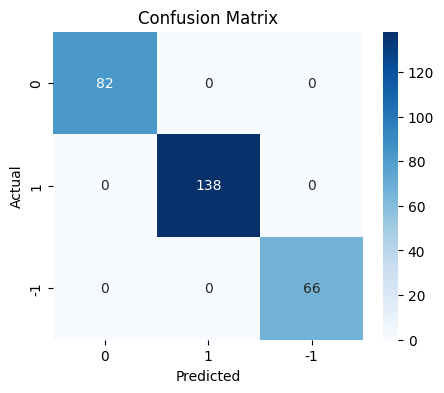

In [ ]:
plot_confusion_matrix(base_wv,X_train_wv,y_train)

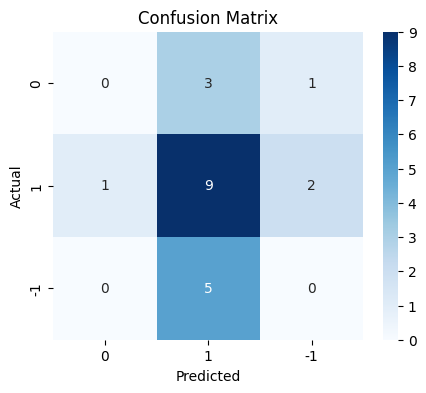

In [ ]:
plot_confusion_matrix(base_wv,X_val_wv,y_val)

In [ ]:
#Calculating different metrics on training data
base_train_wv = model_performance_classification_sklearn(base_wv,X_train_wv,y_train)
print("Training performance:\n", base_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
#Calculating different metrics on validation data
base_val_wv = model_performance_classification_sklearn(base_wv,X_val_wv,y_val)
print("Validation performance:\n",base_val_wv)

Validation performance:
    Accuracy    Recall  Precision       F1
0  0.428571  0.428571   0.302521  0.35468


* There is a significant difference in training performance and validation performance and hence the model seems to be over-fitting

####Base Model - GloVe

In [ ]:
#Building the model


base_gl = GradientBoostingClassifier(random_state = 42)


# Fitting on train data
base_gl.fit(X_train_gl, y_train)

GradientBoostingClassifier(random_state=42)

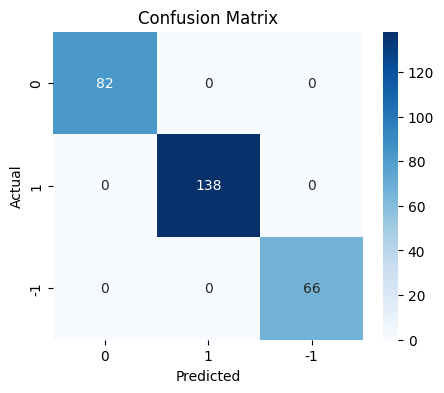

In [ ]:
plot_confusion_matrix(base_gl,X_train_gl,y_train)

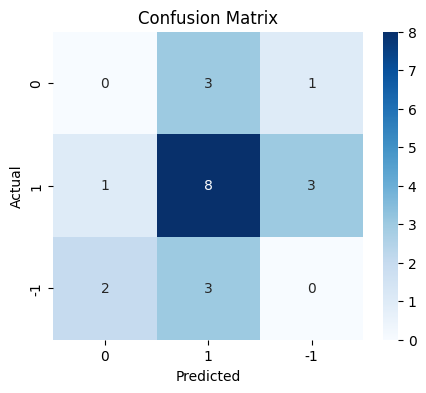

In [ ]:
plot_confusion_matrix(base_gl,X_val_gl,y_val)

In [ ]:
base_train_gl=model_performance_classification_sklearn(base_gl,X_train_gl,y_train)
print("Training performance:\n", base_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
base_val_gl = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_gl)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.326531  0.351648


* The performance difference between training and validation datasets is huge, so this model seems to be over-fitting too




#### Base Model - Sentence Transformer

In [ ]:
# Building the model

base_st = GradientBoostingClassifier(random_state = 42)

# Fitting on train data
base_st.fit(X_train_st, y_train)

GradientBoostingClassifier(random_state=42)

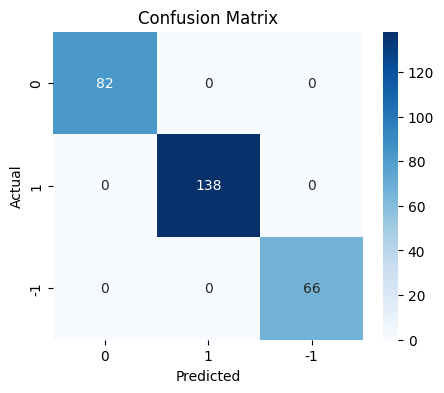

In [ ]:
plot_confusion_matrix(base_st,X_train_st,y_train)

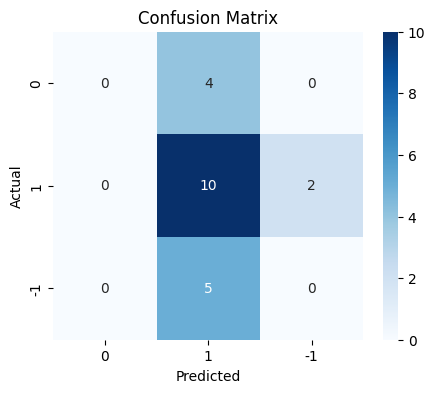

In [ ]:
plot_confusion_matrix(base_st,X_val_st,y_val)

In [ ]:
base_train_st=model_performance_classification_sklearn(base_st,X_train_st,y_train)
print("Training performance:\n", base_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
base_val_st = model_performance_classification_sklearn(base_gl,X_val_gl,y_val)
print("Validation performance:\n",base_val_st)

Validation performance:
    Accuracy    Recall  Precision        F1
0  0.380952  0.380952   0.326531  0.351648


* * The performance difference between training and validation datasets is huge, so this model seems to be over-fitting too

####Tuned Model - Word2Vec

In [ ]:
start = time.time()

# Choosing the classifier corresponsing to the model before
tuned_wv = GradientBoostingClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_wv, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_wv, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_wv = grid_obj.best_estimator_

Time taken  732.2478260993958


In [ ]:
tuned_wv.fit(X_train_wv, y_train)

GradientBoostingClassifier(max_features=0.2, min_samples_split=7,
                           random_state=42)

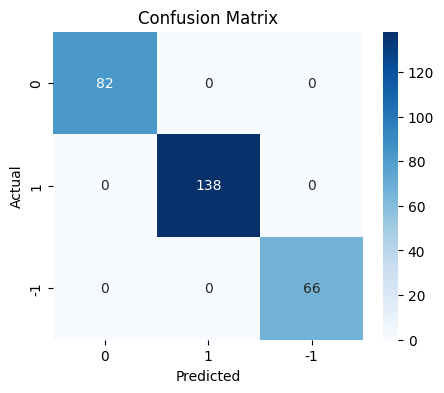

In [ ]:
plot_confusion_matrix(tuned_wv,X_train_wv,y_train)

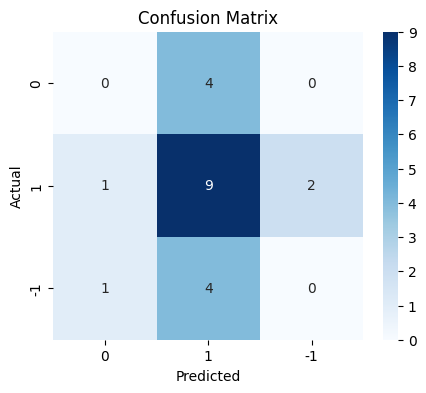

In [ ]:
plot_confusion_matrix(tuned_wv,X_val_wv,y_val)

In [ ]:
tuned_train_wv=model_performance_classification_sklearn(tuned_wv,X_train_wv,y_train)
print("Training performance:\n",tuned_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
tuned_val_wv = model_performance_classification_sklearn(tuned_wv,X_val_wv,y_val)
print("Validation performance:\n",tuned_val_wv)

Validation performance:
    Accuracy    Recall  Precision       F1
0  0.428571  0.428571   0.302521  0.35468


* The model is still over-fitting

####Tuned Model - GloVe

In [ ]:
start = time.time()

tuned_gl = GradientBoostingClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_gl, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_gl, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_gl = grid_obj.best_estimator_

Time taken  432.2325541973114


In [ ]:
#Fit the algorithm to the data
tuned_gl.fit(X_train_gl, y_train)

GradientBoostingClassifier(max_features='log2', min_samples_split=9,
                           random_state=42)

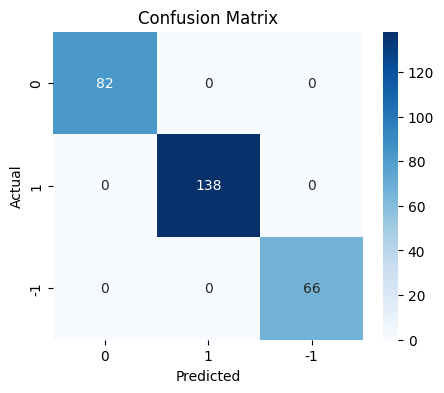

In [ ]:
plot_confusion_matrix(tuned_gl,X_train_gl,y_train)

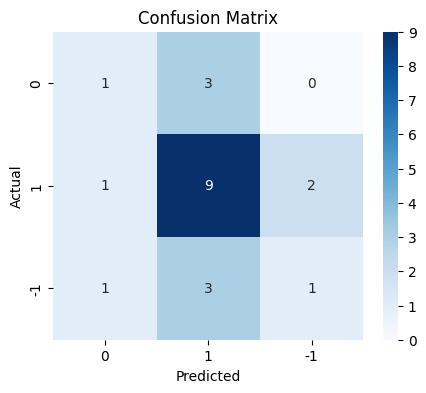

In [ ]:
plot_confusion_matrix(tuned_gl,X_val_gl,y_val)

In [ ]:
tuned_train_gl=model_performance_classification_sklearn(tuned_gl,X_train_gl,y_train)
print("Training performance:\n",tuned_train_gl)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
tuned_val_gl = model_performance_classification_sklearn(tuned_gl,X_val_gl,y_val)
print("Validation performance:\n",tuned_val_gl)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.52381  0.52381   0.485714  0.494898


* The model is still over-fitting the data

####Tuned Model - Sentence Transformer

In [ ]:
start = time.time()

tuned_st = GradientBoostingClassifier(random_state = 42)

parameters = {
    'max_depth': np.arange(3,7),
    'min_samples_split': np.arange(5,12,2),
    'max_features': ['log2', 'sqrt', 0.2, 0.4]
}

# Run the grid search
grid_obj = GridSearchCV(tuned_st, parameters, scoring='f1_weighted',cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train_st, y_train)

end = time.time()
print("Time taken ",(end-start))

# Set the clf to the best combination of parameters
tuned_st = grid_obj.best_estimator_

Time taken  790.8718090057373


In [ ]:
tuned_st.fit(X_train_st, y_train)

GradientBoostingClassifier(max_features='sqrt', min_samples_split=11,
                           random_state=42)

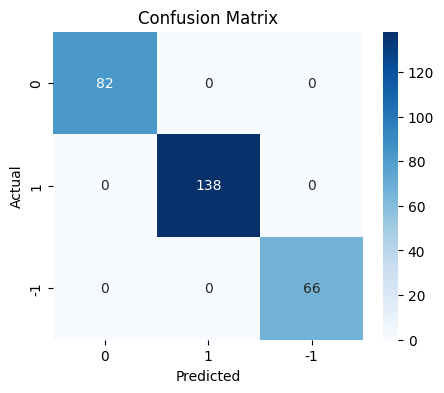

In [ ]:
plot_confusion_matrix(tuned_st,X_train_st,y_train)

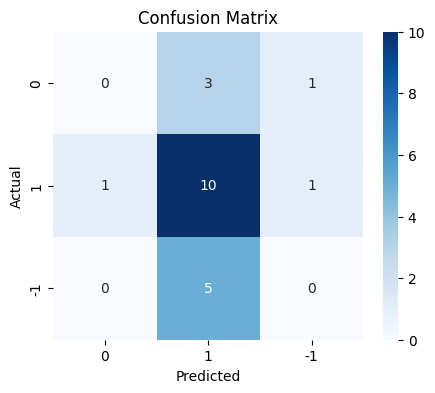

In [ ]:
plot_confusion_matrix(tuned_st,X_val_st,y_val)

In [ ]:
tuned_train_st=model_performance_classification_sklearn(tuned_st,X_train_st,y_train)
print("Training performance:\n",tuned_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [ ]:
tuned_val_st = model_performance_classification_sklearn(tuned_st,X_val_st,y_val)
print("Validation performance:\n",tuned_val_st)

Validation performance:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619    0.31746  0.380952


* The model still is over-fitting the data

####Model Performance Summary and Final Model Selection

In [ ]:
#training performance comparison

models_train_comp_df = pd.concat(
    [base_train_wv.T,
     base_train_gl.T,
     base_train_st.T,
     tuned_train_wv.T,
     tuned_train_gl.T,
     tuned_train_st.T,
    ],axis=1
)

models_train_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,1.0,1.0,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0,1.0,1.0
F1,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
#validation performance comparison

models_val_comp_df = pd.concat(
    [base_val_wv.T,
     base_val_gl.T,
     base_val_st.T,
     tuned_val_wv.T,
     tuned_val_gl.T,
     tuned_val_st.T,
     ],axis=1
)

models_val_comp_df.columns = [
    "Base Model (Word2Vec)",
    "Base Model (GloVe)",
    "Base Model (Sentence Transformer)",
    "Tuned Model (Word2Vec)",
    "Tuned Model (GloVe)",
    "Tuned Model (Sentence Transformer)",
]

print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Base Model (Word2Vec),Base Model (GloVe),Base Model (Sentence Transformer),Tuned Model (Word2Vec),Tuned Model (GloVe),Tuned Model (Sentence Transformer)
Accuracy,0.428571,0.380952,0.380952,0.428571,0.523810,0.476190
Recall,0.428571,0.380952,0.380952,0.428571,0.523810,0.476190
Precision,0.302521,0.326531,0.326531,0.302521,0.485714,0.317460
F1,0.354680,0.351648,0.351648,0.354680,0.494898,0.380952


* All the models overfit the data
* F1 Score of GloVe tuned score is highest, so we will select that as our final model.

####Model Performance Check on Test Data

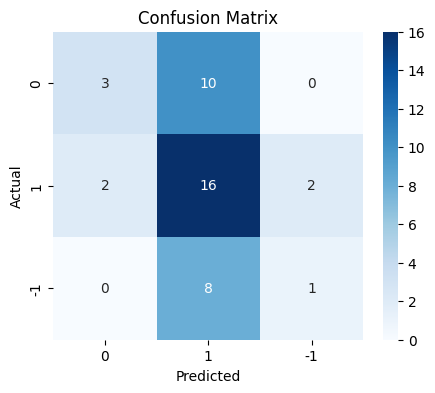

In [ ]:
plot_confusion_matrix(tuned_gl,X_test_gl,y_test)

In [ ]:
#Calculating different metrics on training data
final_model_test = model_performance_classification_sklearn(tuned_gl,X_test_gl,y_test)
print("Test performance for the final model:\n",final_model_test)

Test performance for the final model:
    Accuracy   Recall  Precision        F1
0   0.47619  0.47619   0.481232  0.421076


## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [ ]:
# Installation for GPU llama-cpp-python
# uncomment and run the following code in case GPU is being used
# !CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python -q

# Installation for CPU llama-cpp-python
# uncomment and run the following code in case GPU is not being used
!CMAKE_ARGS="-DLLAMA_CUBLAS=off" FORCE_CMAKE=1 pip install llama-cpp-python -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [ ]:
stock_news = pd.read_csv('/content/drive/MyDrive/AI_ML_Interview/1_AI_ML_Course/8_Introduction_to_Natural_Language_Processing/Project/stock_news.csv')


In [ ]:
data = stock_news.copy()

#### Loading the model

In [ ]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"


model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

In [ ]:
#uncomment the below snippet of code if the runtime is connected to GPU.
# llm = Llama(
#     model_path=model_path, # Path to the model
#     n_gpu_layers=100, #Number of layers transferred to GPU
#     n_ctx=4500, #Context window
# )

In [ ]:
# uncomment and run the following code in case GPU is not being used

llm = Llama(
    model_path=model_path,
    n_ctx=4500, # Context window
    n_cores=-2 # Number of CPU cores to use
)

llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loade

#### Aggregating the data weekly

In [ ]:
data["Date"] = pd.to_datetime(data['Date'])  # Convert the 'Date' column to datetime format.

In [ ]:
# Group the data by week using the 'Date' column.
weekly_grouped = data.groupby(pd.Grouper(key='Date', freq='W'))

In [ ]:
#Aggregare the grouped data on a weekly basis
# concatenate 'content' values into a single string seperated by '||'
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [ ]:
weekly_grouped

,Date,News
0,2019-01-06,The tech sector experienced a significant dec...
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...
2,2019-01-20,The U.S. stock market declined on Monday as c...
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre..."
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...
5,2019-02-10,"The Dow Jones Industrial Average, S&P 500, an..."
6,2019-02-17,"This week, the European Union's second highes..."
7,2019-02-24,This news article discusses progress towards ...
8,2019-03-03,The Dow Jones Industrial Average and other ma...
9,2019-03-10,"Spotify, the world's largest paid music strea..."


In [ ]:
# creating a copy of the data
data_1 = weekly_grouped.copy()

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=400, # maximum number of tokens the model should generate for this task.
      temperature=0.05, # value for temperature.
      top_p=0.9, # value for top_p
      top_k=40, #value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

In [ ]:
news = data_1.loc[0, 'News']

In [ ]:
print(len(news.split(' ')))
news

2611


' The tech sector experienced a significant decline in the aftermarket following Apple\'s Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple\'s downward revision of its revenue expectations for the quarter, previously announced in January. ||  Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple\'s stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10 ||  Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple\'s shares fell 8.5% in post market trading, while Asian suppliers like Hon ||  This news article reports that yields o

In [ ]:
#Complete the code to define the prompt for this task
prompt = """
    You're an expert in stock market news summarization.
    You'll be provided with multiple news articles, each seperated by '||'.
    Read through each of the news articles and extract the top three positive and negative aspects that could potentially impact the stock's performance.
    Consider factors such as market trends, company announcements, economic indicators, and any other relevant information.
    Return in a JSON format as follows:
    {"Positive Aspects": [point_1, point_2,point_3], "Negative Aspects": [point_1, point_2,point_3]}
    Return only the JSON output and nothing else.
    """

In [ ]:
#news_1=data['News'].iloc[0]

In [ ]:
%%time
summary = response_mistral_1(prompt, news)
print(summary)

Llama.generate: 236 prefix-match hit, remaining 3675 prompt tokens to eval
llama_perf_context_print:        load time =  177947.48 ms
llama_perf_context_print: prompt eval time = 2514946.59 ms /  3675 tokens (  684.34 ms per token,     1.46 tokens per second)
llama_perf_context_print:        eval time =  518743.68 ms /   399 runs   ( 1300.11 ms per token,     0.77 tokens per second)
llama_perf_context_print:       total time = 3034156.84 ms /  4074 tokens


{"Positive Aspects": [
          "Roku Inc announced plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel.",
          "Gold prices reached over six-month highs due to investor concerns over a global economic slowdown and stock market volatility.",
          "The Chinese central bank announced a fifth reduction in the required reserve ratio for banks, freeing up approximately 116.5 billion yuan for new lending."
        ],
        "Negative Aspects": [
          "Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales and weakness in emerging markets.",
          "Yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown.",
          "Apple's revenue warning 

##### Checking the model output on the weekly data

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
%%time
data_1['Key Events'] = data_1['News'].progress_apply(lambda x: response_mistral_1(prompt,x))

  0%|          | 0/18 [00:00<?, ?it/s]Llama.generate: 3910 prefix-match hit, remaining 1 prompt tokens to eval
llama_perf_context_print:        load time = 2259098.70 ms
llama_perf_context_print: prompt eval time = 2338878.35 ms /     2 tokens (1169439.18 ms per token,     0.00 tokens per second)
llama_perf_context_print:        eval time =  468668.31 ms /   399 runs   ( 1174.61 ms per token,     0.85 tokens per second)
llama_perf_context_print:       total time =  499852.73 ms /   401 tokens
 11%|█         | 2/18 [08:19<1:06:39, 249.97s/it]Llama.generate: 166 prefix-match hit, remaining 2234 prompt tokens to eval
llama_perf_context_print:        load time = 2259098.70 ms
llama_perf_context_print: prompt eval time = 1302459.34 ms /  2234 tokens (  583.02 ms per token,     1.72 tokens per second)
llama_perf_context_print:        eval time =  435648.56 ms /   399 runs   ( 1091.85 ms per token,     0.92 tokens per second)
llama_perf_context_print:       total time = 1738512.57 ms /  2633 

CPU times: user 7h 3min 44s, sys: 1min 9s, total: 7h 4min 54s
Wall time: 4h 58min 31s


In [ ]:
data_1["Key Events"].head(5) #print the first 5 rows of the 'Key_Events' column

,Key Events
0,"{""Positive Aspects"": [\n ""Roku Inc an..."
1,"{""Positive Aspects"": [\n ""Sprint and Sa..."
2,"{""Positive Aspects"": [\n ""Dialog Semi..."
3,"{""Positive Aspects"": [\n ""IBM reported ..."
4,"{""Positive Aspects"": [\n ""Apple repor..."


##### Formatting the model output

In [ ]:
data_1['model_response_parsed'] = data_1['Key Events'].apply(extract_json_data)
data_1.head()

          "Roku Inc announced plans to offer premium video channels on a subscription basis through its free streaming service, The Roku Channel.",
          "Gold prices reached over six-month highs due to investor concerns over a global economic slowdown and stock market volatility.",
          "The Chinese central bank announced a fifth reduction in the required reserve ratio (RRR) for banks, freeing up approximately 116.5 billion yuan for new lending."
        ],
        "Negative Aspects": [
          "Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades.",
          "Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency.",
          "Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets.",
        

,Date,News,Key Events,model_response_parsed
0,2019-01-06,The tech sector experienced a significant dec...,"{""Positive Aspects"": [\n ""Roku Inc an...",{}
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,"{""Positive Aspects"": [\n ""Sprint and Sa...",{}
2,2019-01-20,The U.S. stock market declined on Monday as c...,"{""Positive Aspects"": [\n ""Dialog Semi...",{}
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...","{""Positive Aspects"": [\n ""IBM reported ...",{'Positive Aspects': ['IBM reported better-tha...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,"{""Positive Aspects"": [\n ""Apple repor...",{'Positive Aspects': ['Apple reported stronger...


In [ ]:
model_response_parsed = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed.head()

,Positive Aspects,Negative Aspects
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,[IBM reported better-than-expected earnings an...,[Swiss National Bank governor emphasized the n...
4,[Apple reported stronger-than-expected earning...,[Caterpillar reported lower-than-expected four...


In [ ]:
final_output = pd.concat([data_1.reset_index(drop=True),model_response_parsed],axis=1)
final_output.drop(['Key Events','model_response_parsed'], axis=1, inplace=True)
final_output.columns = ['Week End Date', 'News', 'Week Positive Events', 'Week Negative Events']

final_output.head()

,Week End Date,News,Week Positive Events,Week Negative Events
0,2019-01-06,The tech sector experienced a significant dec...,NaN,NaN
1,2019-01-13,Sprint and Samsung plan to release 5G smartph...,NaN,NaN
2,2019-01-20,The U.S. stock market declined on Monday as c...,NaN,NaN
3,2019-01-27,"The Swiss National Bank (SNB) governor, Andre...",[IBM reported better-than-expected earnings an...,[Swiss National Bank governor emphasized the n...
4,2019-02-03,Caterpillar Inc reported lower-than-expected ...,[Apple reported stronger-than-expected earning...,[Caterpillar reported lower-than-expected four...


## **Conclusions and Recommendations**

* The weekly news summarization was done by Mistral 7B model and it did a good job of identifying positive and negative event in the week.This will help financial analyst to make informed decisions when developing trade strategies. We can explore combining the news sentiments with daily prices and volumes to help the LLM better identify the key positive and negative event in the week.
* All the models over-fit the data with only Glove Tuned model gave a comparitively better performance than the others.It is recomended to try out other models to try and improve the performance.
* ML models find it difficult to identify the patterns in the news articles because of the complexity of the language used in them. As such, it is recommended to collect more data to allow the model to better understand patterns and context from the news content.
* The stock prices ranges from around 36 to 67 over the 4month data given showing a similar monthly pattern in each month.




<font size=6 color='blue'>Power Ahead</font>
___